-------------------------------------------
<div>
<img src="https://www.bournemouth.ac.uk/sites/all/themes/bournemouth/assets/images/logo-horizontal.svg" width="400"/>
</div>

| Faculty of Science and Technology           |
| :-----------------------------------------: | 
| MSc. Data Science and Artificial Intelligence
| Master's Dissertation
|       June 2021

-----------------------------------------------

# <div style="text-align: center">Modelling of Missing Values in Medical Time Series Data</div>
### <div style="text-align: center">Pooja Bhande</div>


In [ ]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from datetime import datetime
from datetime import timedelta
import seaborn as sns
%matplotlib inline
import missingno as msno
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.metrics import roc_auc_score
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import NearMiss
from sklearn.utils import resample
from keras.utils import np_utils
from google.cloud import storage
from google.colab import drive
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import itertools  
from sklearn.model_selection import GroupShuffleSplit
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Connect to Google Drive  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Uploading the processed dataset
df_final = pd.read_csv('/content/drive/MyDrive/df_final.csv',index_col=0)

In [ ]:
#A quick look at the dataset created
df_final

,icustay_id,charttime,subject_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,first_admit_age,gender,expire_flag,time_step
1055849,222148,2100-06-16 16:00:00,12001.0,93.0,154.0,80.5,109.500000,13.0,NaN,100.0,NaN,71.63,0.0,0.0,0
1055850,222148,2100-06-16 17:00:00,12001.0,74.0,128.5,57.0,83.333351,11.0,NaN,100.0,NaN,71.63,0.0,0.0,1
1055851,222148,2100-06-16 18:00:00,12001.0,91.0,169.0,89.0,119.833500,14.0,NaN,98.0,NaN,71.63,0.0,0.0,2
1055852,222148,2100-06-16 19:00:00,12001.0,93.0,167.5,91.0,120.500000,14.0,37.111113,98.0,NaN,71.63,0.0,0.0,3
1055853,222148,2100-06-16 20:00:00,12001.0,88.0,168.5,77.0,110.666500,15.0,NaN,98.0,NaN,71.63,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629361,234115,2209-08-07 12:00:00,25723.0,94.0,96.0,56.0,65.000000,25.0,36.611111,96.0,210.0,54.94,1.0,0.0,43
1629362,234115,2209-08-07 13:00:00,25723.0,74.0,115.0,56.0,71.000000,19.0,NaN,97.0,NaN,54.94,1.0,0.0,44
1629363,234115,2209-08-07 14:00:00,25723.0,74.0,103.0,43.0,57.000000,22.0,NaN,97.0,NaN,54.94,1.0,0.0,45
1629364,234115,2209-08-07 15:00:00,25723.0,90.0,114.0,91.0,97.000000,19.0,NaN,95.0,162.5,54.94,1.0,0.0,46


In [ ]:
#re-initializing the variables used in the previous notebook

variables = ['icustay_id','subject_id','HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose','first_admit_age','gender','time_step','expire_flag']
ts_variables = ['HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose']

# Exploratory Data Analysis (Cont'd)

In the last section we explored the missingness properties, here we will look at the overall distribution in the dataset, feature properties and trends in the data.

We will first print a boxplot to see the statistical distribution of data. The outcome is partitioned by survivors and non survivors in the dataset.

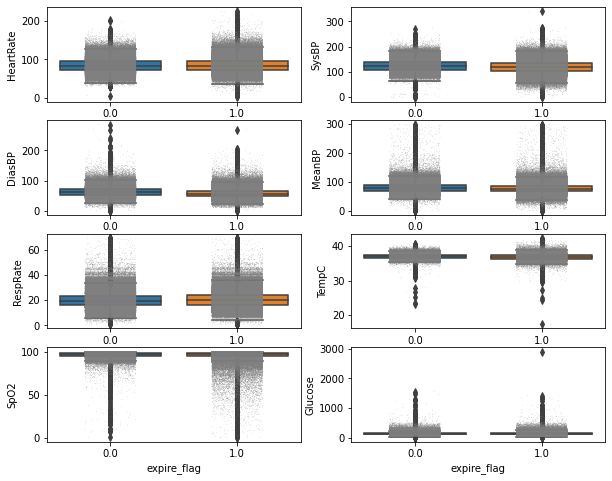

In [ ]:

fig = plt.figure(figsize=(10,8))
count = 0
for variable in ts_variables:
    count += 1
    plt.subplot(4, 2, count)
  
    
    # same but partitioned by outcome
    ax = sns.boxplot(x = 'expire_flag', y=variable, data=df_final)
    ax = sns.stripplot(x = 'expire_flag', y=variable, data=df_final, color='grey', jitter=0.2, size=0.5)

plt.show()

In order to investigate trends across time , it is useful to visualize the mean of all the time series variables from time steps t=0 to t=47 partitioned by the corresponding mortality status .  

Plotting 1222651 observations - HeartRate
Plotting 1168056 observations - SysBP
Plotting 1167796 observations - DiasBP
Plotting 1166058 observations - MeanBP
Plotting 1200171 observations - RespRate
Plotting 354087 observations - TempC
Plotting 1152076 observations - SpO2
Plotting 245952 observations - Glucose


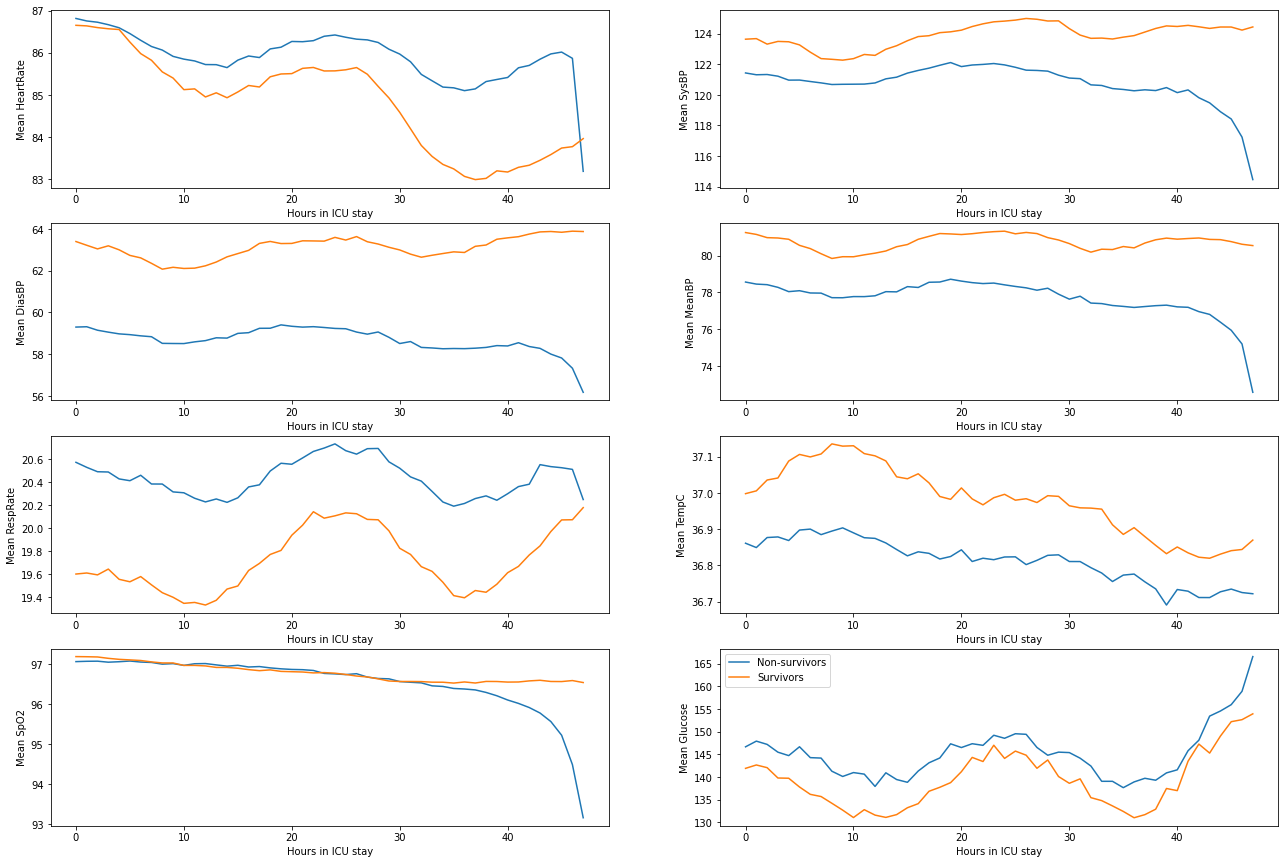

In [ ]:
fig = plt.figure(figsize=(22,15))
count = 0
for variable in ts_variables:
    count += 1
    data4clustering = df_final.pivot(columns='time_step', values=variable)
    print('Plotting ' + str(data4clustering.count().sum()) + ' observations - ' + variable)    
    class1 = data4clustering.loc[df_final[df_final['expire_flag']==1].index.unique()].mean()
    class0 = data4clustering.loc[df_final[df_final['expire_flag']==0].index.unique()].mean()
    plt.subplot(4, 2, count)
    plt.plot(class1)
    plt.plot(class0)
    plt.xlabel('Hours in ICU stay')
    plt.ylabel('Mean ' + variable)

plt.legend(['Non-survivors', 'Survivors'])    
plt.show()

From the plot above we can see the physiological improvement or deterioration over the 48-hour period is very different for survival and non-survival groups. Following observations could be made from reviewing the trends:

*   Heart Rate

    -Lower in survivor groups

    -Sharply drops off below 85 in the last few hours of non-survivor groups
*   Systolic Blood Pressure

      -Higher in survivor groups

      -Sharply drops from 120 to lower values in the last few hours of the non-survivor groups
*   Diastolic Blood Pressure

    -Similar patterns observed in Mean and Systolic blood pressures
*   Respiratory Rate

     -Higher rates in non-survivors 

    -Fluctuation of values follow similar pattern between survivors and 
    non-survivors until first 35 hours
*   Temperature

    -Higher in survivor groups

    -Goes down to very low values in last 10 hours for non-survivor groups
*   SpO2

    -Follows pretty much same trend until last 8-10 hours for both the
    groups but the values drastically fall for the non-survivor groups in 
    the last leg.
*   Glucose

    -Fluctuation in values follows similar patterns in both the groups.
    -Values are slightly higher for non survivors, but it shoots up to much 
    higher levels in the last few hours for non-survivor groups







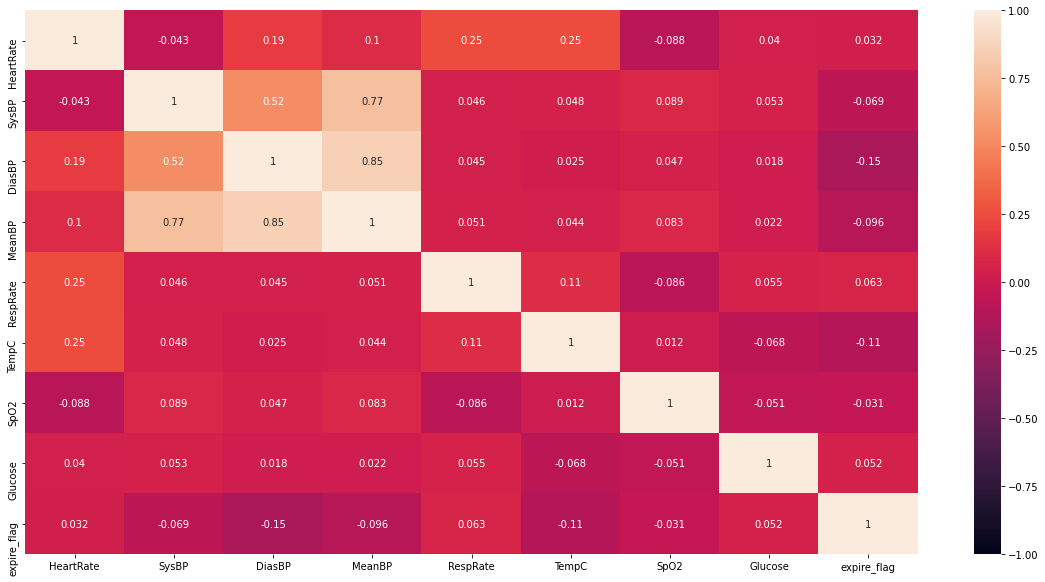

In [ ]:
#lets see the correlation matrix for the entire dataset
plt.figure(figsize=(20,10))
sns.heatmap(df_final[ts_variables + ['expire_flag']].corr(),annot=True,vmin=-1, vmax=1)
plt.show()

From the corelation matrix, we can infere that the Blood pressure readings are highly co-related however we shall still retain these features since these features are found to be predictive when training the models



---


# Training and Testing Data Split

The dataset is split into 3 categories of Training, Validation and Test Data set. 80% of the data is used to train the model, and the remaining 20% is split for Validation and Test Datasets. 

In [ ]:
# split data into train, validation and test set
id_train, id_test = train_test_split(df_final.icustay_id.unique(), test_size=0.2, random_state=0)
id_train, id_val = train_test_split(id_train, test_size=0.2, random_state=0)
id_train.sort()
id_val.sort()
id_test.sort()

We will next check for the class balance in the Training Dataset

Percentage Split of the Mortality Classes in the Training Dataset
No. of instances of survivor classes:  8427.0
Percentage of survivor class: 0.51 %
No. of instances of non-survivor classes:  8064.0
Percentage of non-survivor class: 0.49 %



Text(0, 0.5, 'Mortality Count')

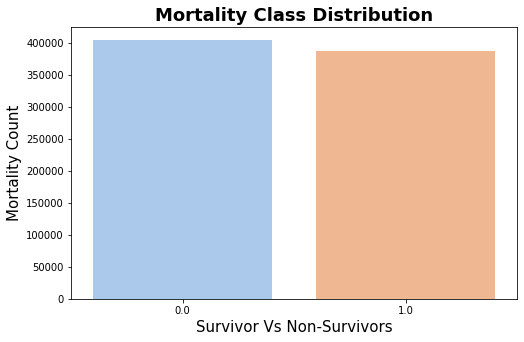

In [ ]:
df_train = df_final[df_final.icustay_id.isin(id_train)]
print('Percentage Split of the Mortality Classes in the Training Dataset')
print('No. of instances of survivor classes: ',df_train.expire_flag.value_counts()[0]/48)
print('Percentage of survivor class:',round(df_train.expire_flag.value_counts()[0]/len(df_train),2),'%')
print('No. of instances of non-survivor classes: ',df_train.expire_flag.value_counts()[1]/48)
print('Percentage of non-survivor class:',round(df_train.expire_flag.value_counts()[1]/len(df_train),2),'%\n')
labels = ['Survivors','Non-Survivors']
countplt, ax = plt.subplots(figsize = (8,5))
ax =sns.countplot(x = 'expire_flag', data=df_train, palette='pastel')
ax.set_title('Mortality Class Distribution',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Survivor Vs Non-Survivors', fontsize = 15)
ax.set_ylabel('Mortality Count', fontsize = 15)
#ax.legend(['Survivors','Non-survivors'])


The dataset is fairly balanced therefore we can move forward without the need to resample the dataset to balance the class distribution.

# Dataset Preparation for capturing the Missing Data Indicators

Before we move on with the training of dataset, we will build the datasets based on the modelling techniques discussed in the dissertation. For reviewing the performance of RNN LSTM and MLP models, following datasets will be constructed

1. Zero Imputation only
2. Forwardfill Imputation

3. Zero Imputation with indicators

4. Forwardfill with indicators

5. With Indicators only


---

And for the rest of the models that cannot capture sequential data, we will be creating hand-engineered features and the datasets considered for these models are:

1. Measurement only
2. Indicators only
3. Measurement with indicators


We will first create the Missing Data indicators before we begin with the construction of the datasets

In [ ]:
#Setting the indicators as '0' on observed data and '1' on non observed data (1)
df_indicators=df_final.copy()

for i in df_indicators.columns[3:-4]: #including only the time series variables
  df_indicators[i+'_indicator'] = np.where(df_indicators[i].notnull(),0,1)

#storing the indicator variables to a list
indicator_variables = (df_indicators.columns[-(len(ts_variables)):]).to_list()
indicator_variables

['HeartRate_indicator',
 'SysBP_indicator',
 'DiasBP_indicator',
 'MeanBP_indicator',
 'RespRate_indicator',
 'TempC_indicator',
 'SpO2_indicator',
 'Glucose_indicator']

In [ ]:
#Check the indicator variables created
df_indicators.head()

,icustay_id,charttime,subject_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,first_admit_age,gender,expire_flag,time_step,HeartRate_indicator,SysBP_indicator,DiasBP_indicator,MeanBP_indicator,RespRate_indicator,TempC_indicator,SpO2_indicator,Glucose_indicator
1055849,222148,2100-06-16 16:00:00,12001.0,93.0,154.0,80.5,109.500000,13.0,NaN,100.0,NaN,71.63,0.0,0.0,0,0,0,0,0,0,1,0,1
1055850,222148,2100-06-16 17:00:00,12001.0,74.0,128.5,57.0,83.333351,11.0,NaN,100.0,NaN,71.63,0.0,0.0,1,0,0,0,0,0,1,0,1
1055851,222148,2100-06-16 18:00:00,12001.0,91.0,169.0,89.0,119.833500,14.0,NaN,98.0,NaN,71.63,0.0,0.0,2,0,0,0,0,0,1,0,1
1055852,222148,2100-06-16 19:00:00,12001.0,93.0,167.5,91.0,120.500000,14.0,37.111113,98.0,NaN,71.63,0.0,0.0,3,0,0,0,0,0,0,0,1
1055853,222148,2100-06-16 20:00:00,12001.0,88.0,168.5,77.0,110.666500,15.0,NaN,98.0,NaN,71.63,0.0,0.0,4,0,0,0,0,0,1,0,1


We now move ahead with the creation of the datasets for RNN and LSTM models as discussed in the above section

In [ ]:
#Zero Impuation Dataset - Replacing all the null values with Zero
df_zo = df_final.fillna(0)
df_zo = df_zo[variables]
df_zo.head()

,icustay_id,subject_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,first_admit_age,gender,time_step,expire_flag
1055849,222148,12001.0,93.0,154.0,80.5,109.500000,13.0,0.000000,100.0,0.0,71.63,0.0,0,0.0
1055850,222148,12001.0,74.0,128.5,57.0,83.333351,11.0,0.000000,100.0,0.0,71.63,0.0,1,0.0
1055851,222148,12001.0,91.0,169.0,89.0,119.833500,14.0,0.000000,98.0,0.0,71.63,0.0,2,0.0
1055852,222148,12001.0,93.0,167.5,91.0,120.500000,14.0,37.111113,98.0,0.0,71.63,0.0,3,0.0
1055853,222148,12001.0,88.0,168.5,77.0,110.666500,15.0,0.000000,98.0,0.0,71.63,0.0,4,0.0


In [ ]:
#Zero Imputation with Indicators - Including the indicator variables for every time series variables

df_zi = df_indicators.copy()
df_zi = df_zi[['icustay_id'] + ts_variables+ indicator_variables + ['gender','first_admit_age','time_step','expire_flag']]
df_zi = df_zi.fillna(0)
df_zi.head()

,icustay_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,HeartRate_indicator,SysBP_indicator,DiasBP_indicator,MeanBP_indicator,RespRate_indicator,TempC_indicator,SpO2_indicator,Glucose_indicator,gender,first_admit_age,time_step,expire_flag
1055849,222148,93.0,154.0,80.5,109.500000,13.0,0.000000,100.0,0.0,0,0,0,0,0,1,0,1,0.0,71.63,0,0.0
1055850,222148,74.0,128.5,57.0,83.333351,11.0,0.000000,100.0,0.0,0,0,0,0,0,1,0,1,0.0,71.63,1,0.0
1055851,222148,91.0,169.0,89.0,119.833500,14.0,0.000000,98.0,0.0,0,0,0,0,0,1,0,1,0.0,71.63,2,0.0
1055852,222148,93.0,167.5,91.0,120.500000,14.0,37.111113,98.0,0.0,0,0,0,0,0,0,0,1,0.0,71.63,3,0.0
1055853,222148,88.0,168.5,77.0,110.666500,15.0,0.000000,98.0,0.0,0,0,0,0,0,1,0,1,0.0,71.63,4,0.0


In [ ]:
# Forward Fill Imputation

#grouping is done to ensure values are copied from within 48- hour window period of each ICU stay
df_fo = df_final.groupby('icustay_id')[variables].fillna(method='ffill')
#replacing nan values missing at time step 0 with group's median
df_fo = df_fo.groupby('icustay_id')[variables].fillna(value=df_fo[variables].mean())
df_fo = df_fo.reset_index('icustay_id',drop=True)
df_fo[df_fo['icustay_id'] == 222148].head(10)

In [ ]:
#Forward Fill Imputation With Indicators

df_fi = df_fo.copy()
#Joining the indicators variables to the forward fill imputed values
df_fi = pd.concat([df_fi,df_indicators[indicator_variables]],axis=1)
df_fi.head()

In [ ]:
#Missing Indicators only

#Including only the time series variables since Age and Gender do not provide any missing indicator since they are always filled
df_io = df_indicators[['icustay_id'] + indicator_variables +['time_step','expire_flag']]
df_io.head()

Now we move on to create the Feature and Target class for Training, Validation and Testing datasets

Each dataset type will first be split to three categories followed by assignment of target and feature classes.

In [ ]:
#Splitting each dataset type to Training, Validation and Testing datasets

#Zero Imputation Datasets

x_train_zo = (df_zo[df_zo.icustay_id.isin(id_train)]).sort_values(by=['icustay_id','time_step'])
x_val_zo = (df_zo[df_zo.icustay_id.isin(id_val)]).sort_values(by=['icustay_id','time_step'])
x_test_zo = (df_zo[df_zo.icustay_id.isin(id_test)]).sort_values(by=['icustay_id','time_step'])


#Zero Imputation with indicators
x_train_zi = (df_zi[df_zi.icustay_id.isin(id_train)]).sort_values(by=['icustay_id','time_step'])
x_val_zi = (df_zi[df_zi.icustay_id.isin(id_val)]).sort_values(by=['icustay_id','time_step'])
x_test_zi = (df_zi[df_zi.icustay_id.isin(id_test)]).sort_values(by=['icustay_id','time_step'])

#Forward Filled Dataset
x_train_fo = (df_fo[df_fo.icustay_id.isin(id_train)]).sort_values(by=['icustay_id','time_step'])
x_val_fo = (df_fo[df_fo.icustay_id.isin(id_val)]).sort_values(by=['icustay_id','time_step'])
x_test_fo = (df_fo[df_fo.icustay_id.isin(id_test)]).sort_values(by=['icustay_id','time_step'])

#Forward fill with indicators
x_train_fi = (df_fi[df_fi.icustay_id.isin(id_train)]).sort_values(by=['icustay_id','time_step'])
x_val_fi = (df_fi[df_fi.icustay_id.isin(id_val)]).sort_values(by=['icustay_id','time_step'])
x_test_fi = (df_fi[df_fi.icustay_id.isin(id_test)]).sort_values(by=['icustay_id','time_step'])

#Indicators only
x_train_io = (df_io[df_io.icustay_id.isin(id_train)]).sort_values(by=['icustay_id','time_step'])
x_val_io = (df_io[df_io.icustay_id.isin(id_val)]).sort_values(by=['icustay_id','time_step'])
x_test_io = (df_io[df_io.icustay_id.isin(id_test)]).sort_values(by=['icustay_id','time_step'])



In [ ]:
#Creating the feature and target classes

features = ['HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose','first_admit_age','gender']

#Zero Imputation Dataset

y_train_zo = x_train_zo.groupby('icustay_id')['expire_flag'].mean() #to extract one output for every 48 hour sequential input and to fit it in output node for the neural models
x_train_zo = x_train_zo[features]
y_test_zo = x_test_zo.groupby('icustay_id')['expire_flag'].mean()
x_test_zo = x_test_zo[features]
y_val_zo = x_val_zo.groupby('icustay_id')['expire_flag'].mean()
x_val_zo = x_val_zo[features]


#Zero Imputation with Indicators

y_train_zi = x_train_zi.groupby('icustay_id')['expire_flag'].mean() 
x_train_zi = x_train_zi[features+indicator_variables] #including the missing indicator variables to the feature list
y_test_zi = x_test_zi.groupby('icustay_id')['expire_flag'].mean()
x_test_zi = x_test_zi[features+indicator_variables]
y_val_zi = x_val_zi.groupby('icustay_id')['expire_flag'].mean()
x_val_zi = x_val_zi[features+indicator_variables]

#Forward Fill Datasets

y_train_fo = x_train_fo.groupby('icustay_id')['expire_flag'].mean() 
x_train_fo = x_train_fo[features] 
y_test_fo = x_test_fo.groupby('icustay_id')['expire_flag'].mean()
x_test_fo = x_test_fo[features]
y_val_fo = x_val_fo.groupby('icustay_id')['expire_flag'].mean()
x_val_fo = x_val_fo[features]

#Forward fill with indicators

y_train_fi = x_train_fi.groupby('icustay_id')['expire_flag'].mean() 
x_train_fi = x_train_fi[features+indicator_variables] 
y_test_fi = x_test_fi.groupby('icustay_id')['expire_flag'].mean()
x_test_fi = x_test_fi[features+indicator_variables]
y_val_fi = x_val_fi.groupby('icustay_id')['expire_flag'].mean()
x_val_fi = x_val_fi[features+indicator_variables]

#Indicators only

y_train_io = x_train_io.groupby('icustay_id')['expire_flag'].mean() 
x_train_io = x_train_io[indicator_variables] #adding only the indicator variables to the feature list
y_test_io = x_test_io.groupby('icustay_id')['expire_flag'].mean()
x_test_io = x_test_io[indicator_variables]
y_val_io = x_val_io.groupby('icustay_id')['expire_flag'].mean()
x_val_io = x_val_io[indicator_variables]


Shaping the time series data to input the neural network models

In [ ]:
#Function to convert the two dimensional datasets to 3-dimensional for running on the neural models
def _2d_to_3d(X, n_steps):
    _X = np.zeros((X.shape[0]//n_steps,n_steps,X.shape[1]))
    for i in range(len(X)//n_steps):
        _X[i,:] = X[i*n_steps:i*n_steps+n_steps]
    return _X

In the above section we created the datasets for feeding the RNN and MLP models, next we will be creating the hand engineered features for training rest of the models. Following section will show how these features are extracted.

# Feature Engineering for Non-Neural Network models

In order to review the performance of Classifier models which are not best suited for sequential data input, we constructed features to extract meaningful information from the sequential data. The data will be transformed using the following aggregation operators on the time series variables:
1. Maximum
2. Minimum
3. Standard Deviation
4. Mean
5. First Measurement
6. Last Measurement
7. 25th Percentile
8. 75th Percentile

We will be running these extracted features on following datasets:
1. Measurement only 
2. Measurement and Indicators
3. Indicators only

The models considered for training from the hand-engineered features are:
1. Logistic Regression
2. Decision Tree
3. Random Forest Classifier

In [ ]:
#Function to extract the aggregrated features

def feat_extract(data,variables):

    data_max = data.groupby(['icustay_id'])[variables].max()
    data_max.columns = ['max_' + str(col) for col in data_max.columns]

    data_min = data.groupby(['icustay_id'])[variables].min()
    data_min.columns = ['min_' + str(col) for col in data_min.columns]
    
    data_sd = data.groupby(['icustay_id'])[variables].std()
    data_sd.columns = ['sd_' + str(col) for col in data_sd.columns]

    data_mean = data.groupby(['icustay_id'])[variables].mean()
    data_mean.columns = ['mean_' + str(col) for col in data_mean.columns]

    data_first = data.groupby(['icustay_id'])[variables].first()
    data_first.columns = ['first_' + str(col) for col in data_first.columns]

    data_last = data.groupby(['icustay_id'])[variables].last()
    data_last.columns = ['last_' + str(col) for col in data_last.columns]

    data_median = data.groupby(['icustay_id'])[variables].mean()
    data_median.columns = ['mean_' + str(col) for col in data_median.columns]

    data_75 = data.groupby(['icustay_id'])[variables].quantile(.75)
    data_75.columns = ['75th%_' + str(col) for col in data_75.columns]

    data_25 = data.groupby(['icustay_id'])[variables].quantile(.25)
    data_25.columns = ['25th%_' + str(col) for col in data_25.columns]

    data_agg = pd.concat([data_min,data_max,data_sd,data_mean,data_first,data_last,data_median,data_75,data_25],axis=1)
    
    return data_agg

Creating Datasets from the hand - Engineered features 

In [ ]:
#Measurements Only Dataset

#Copying the original dataset
df_mo = df_final.copy()
#Extract the features on this dataset
variables_mo = ['icustay_id']+ts_variables
df_mo = feat_extract(df_mo,ts_variables).dropna(axis=0)

df_temp = df_final.set_index('icustay_id')
expire_flag = df_temp.loc[df_mo.index]['expire_flag'].groupby(['icustay_id']).mean()
age = df_temp.loc[df_mo.index]['first_admit_age'].groupby(['icustay_id']).mean()
gender = df_temp.loc[df_mo.index]['gender'].groupby(['icustay_id']).mean()

df_mo = pd.concat([df_mo, age, gender, expire_flag], axis=1).dropna(axis=0)
df_mo.head()
#df_m= df_mo.copy()

Next we create the dataset for Indicator values 

In [ ]:
#Copying the Indicator only dataset created for Neural models
df_i = df_io.copy()

#Extracting the indicator variables from the dataset
df_i = feat_extract(df_i,indicator_variables)

df_temp = df_final.set_index('icustay_id')
expire_flag = df_temp.loc[df_mo.index]['expire_flag'].groupby(['icustay_id']).mean()
age = df_temp.loc[df_mo.index]['first_admit_age'].groupby(['icustay_id']).mean()
gender = df_temp.loc[df_mo.index]['gender'].groupby(['icustay_id']).mean()

df_i = pd.concat([df_i, age, gender, expire_flag], axis=1).dropna(axis=0)
df_i.head()

Creating the dataset with Measurements and Indicators 

In [ ]:
#Joining the above two datasets to create measurement and indicator dataset
df_mi = pd.merge(df_mo,df_i, on=['icustay_id','expire_flag','first_admit_age','gender'], how='inner')

All the Datasets for running on Neural and Non Neural models has been created, we will next move on to training the models with the datasets prepared.

# Recurrent Neural Network  - Long Short Term Memory

The first model to be implemented would be the RNN LSTM model, below function defines the architecture of the LSTM model. The model performance will be checked against all the dataset types created.

In [ ]:
#LSTM model

def lstm_model(x_train, y_train, x_val, y_val, n1, n2, drop_out, batch_size, epochs,lr,decay):

  #Standardize the values
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_val = scaler.fit_transform(x_val)

  #Reshaping the input to fit into the model
  x_train = _2d_to_3d(x_train,n_steps=48)
  x_val = _2d_to_3d(x_val,n_steps=48)

  #Extracting the time_steps and features
  time_steps = x_train.shape[1]
  features = x_train.shape[2]
  
  #Define model
  model=Sequential()
  model.add(LSTM(n1,input_shape=(time_steps,features), activation='tanh', return_sequences=True))
  model.add(Dropout(drop_out))
  model.add(LSTM(n2, activation='tanh', return_sequences=True))
  model.add(Dropout(drop_out))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(Dropout(drop_out))
  model.add(Dense(1,activation='sigmoid'))
  #Setting the learning rate and weight decay values
  adam = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay) #1e-4, decay=1e-6
  model.compile(loss='binary_crossentropy',optimizer=adam,metrics=[tf.keras.metrics.AUC()])

  #Fitting the model
  model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs, verbose=1, validation_data=(x_val,y_val))
  
  return model


We will also create the function to evaluate the model's performance on each dataset type

In [ ]:
#Confusion Matrix Creation
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      #  print("Normalized confusion matrix")
    #else:
     #   print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Function to generate the Confusion Matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        #group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    #else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


############################################################################################################################


#######################Evaluation function to review the LSTM model performance##############################################


def model_eval(model,x_test,y_test):
  
  #Standardize the values
  scaler = MinMaxScaler()
  x_test = scaler.fit_transform(x_test)

  #Reshaping the input to match the model parameters
  x_test = _2d_to_3d(x_test,n_steps=48)

  #yhat_probs = model.predict_proba(x_test)
  yhat_probs = model.predict(x_test)
  yhat_probs = yhat_probs[:,0]
  yhat_classes = model.predict_classes(x_test)
  #yhat_classes = np.argmax(model.predict(x_test), axis=-1)
  yhat_classes = yhat_classes[:,0]

  #Confusion Matrix
  #cm_plot_labels = ['survivors','non-survivors']
  #plot_confusion_matrix(cm=confusion_matrix(y_true=y_test, y_pred=yhat_classes), classes=cm_plot_labels, title='Confusion Matrix')

  cf_matrix = confusion_matrix(y_true=y_test, y_pred=yhat_classes)
  labels = ['True Neg','False Pos','False Neg','True Pos']
  categories = ['Survivors', 'Non-Survivors']
  make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='icefire')

  #Printing the classification report
  #print('\n\n',classification_report(y_test, yhat_classes))
  y_pred = model.predict(x_test).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  auc1 = metrics.auc(fpr, tpr)
  print('AUC Score = ',round(auc1,4))
  plt.figure(2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc1))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

We now run the model on each type of dataset for LSTM model and look at its corresponding results. The metrics used to evaluate the results are AUC ROC curves, confusion matrix, Precision, Recall and F1 scores

# Zero Imputation Dataset - LSTM Results

In [ ]:

#Zero Imputation 
model_zo = lstm_model(x_train_zo,y_train_zo,x_val_zo,y_val_zo,n1=128,n2=64,drop_out=0.4, batch_size=64,epochs=40,lr=1e-4,decay=1e-6)


Epoch 1/40
115/258 [============>.................] - ETA: 6s - loss: 0.6787 - auc_10: 0.6031

In [ ]:
print('\n*****************Zero Imputation*******************\n')
model_eval(model_zo,x_test_zo,y_test_zo)

# Zero Imputation with Indicators - LSTM Results

In [ ]:
#Zero Imputation with indicators
print('**************************************Zero Imputation with indicators************************************')
model_zi = lstm_model(x_train_zi,y_train_zi,x_val_zi,y_val_zi,n1=128,n2=128,drop_out=0.4, batch_size=32,epochs=45,lr=1e-4,decay=1e-6)



In [ ]:
print('\n\n*****************Zero Imputation with indicators*******************\n\n')
model_eval(model_zi,x_test_zi,y_test_zi)

In [ ]:
#model_zi.save('/content/drive/MyDrive')

# Forward Fill Dataset - LSTM Results

In [ ]:
#Forward fill imputation 
print('\n\n**************************************Forward fill Imputation*******************************************')
model_fo = lstm_model(x_train_fo,y_train_fo,x_val_fo,y_val_fo,n1=128,n2=64,drop_out=0.5, batch_size=64,epochs=40,lr=1e-4,decay=1e-7)



In [ ]:
print('\n\n*****************Forward Fill only****************************\n\n')
model_eval(model_fo,x_test_fo,y_test_fo)

In [ ]:
model_eval(model_fo,x_val_fo,y_val_fo)

# Forward Fill with Indicators - LSTM Results

In [ ]:
#Forward fill with indicators 
print('\n\n**************************************Forward fill with indicatorss************************************')
model_fi = lstm_model(x_train_fi,y_train_fi,x_val_fi,y_val_fi,n1=128,n2=64,drop_out=0.5, batch_size=64,epochs=45,lr=1e-4,decay=1e-7)



In [ ]:
print('\n\n*****************Forward Fill with Indicators****************************\n\n')
model_eval(model_fi,x_test_fi,y_test_fi)

# Indicators only Dataset - LSTM Results

In [ ]:
#Indicators only
print('\n\n************************************** Indicators Only************************************************')
model_io = lstm_model(x_train_io,y_train_io,x_val_io,y_val_io,n1=256,n2=256,drop_out=0.5, batch_size=64,epochs=50,lr=1e-4,decay=1e-7)

In [ ]:
print('\n\n*****************Indicators Only****************************\n\n')
model_eval(model_io,x_test_io,y_test_io)

Let's look at the collective plot of ROC curves for all the datasets

In [ ]:
# Add all the model results and datasets types to a list
models = [model_zo,model_fo,model_zi,model_fi,model_io]
datasets_lstm = [x_test_zo,x_test_fo,x_test_zi,x_test_fi,x_test_io]
y_test = y_test_zo

datasets1 = []
for i in datasets_lstm:
  #Standardize the values
  scaler = MinMaxScaler()
  i = scaler.fit_transform(i)
  #Reshaping the input to match the model parameters
  i = _2d_to_3d(i,n_steps=48)
  datasets1.append(i)

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['datasets', 'fpr','tpr','auc'])

res = dict(zip(models, datasets1)) 

# Train the models and record the results
for model, x_test in res.items():
   #model = cls.fit(X_train, y_train)
    yproba = model.predict(x_test).ravel()
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  yproba)
    auc = metrics.roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'datasets':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('datasets', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12,8))

dataset = ['Zero_Imputation_Only','Forward_Fill_Only','Zero_Imputation_with_Indicators','Forward_Fill_with_Indicators','Indicators_Only']
result_table['dataset'] = dataset
result_table = result_table.set_index('dataset')

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for LSTM Model across All Datasets', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Next we will continue the experiment with Multilayer Perceptron Models

# Multilayer Perceptron

In [ ]:
def model_mlp(x_train, y_train, x_val, y_val, n1, n2, n3,drop_out,epochs):
  
  #Standardize the values
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_val = scaler.fit_transform(x_val)

  #Reshaping the input to fit into the model
  x_train = _2d_to_3d(x_train,n_steps=48)
  x_val = _2d_to_3d(x_val,n_steps=48)
  n_input = x_train.shape[1] * x_train.shape[2]
  x_train = x_train.reshape((x_train.shape[0],n_input))
  n_input_val = x_val.shape[1] * x_val.shape[2]
  x_val = x_val.reshape((x_val.shape[0],n_input_val))

  #Defining the model
  model1 = Sequential()
  model1.add(Dense(n1, activation='relu',input_dim=n_input))
  model1.add(Dropout(drop_out))
  model1.add(Dense(n2, activation='relu'))
  model1.add(Dropout(drop_out))
  model1.add(Dense(n3, activation='relu'))
  model1.add(Dropout(drop_out))
  model1.add(Dense(1, activation= 'sigmoid'))
  #adam = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
  model1.compile(loss= 'binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=[tf.keras.metrics.AUC()])

  #Fitting the model
  model1.fit(x_train,y_train, epochs=epochs,validation_data=(x_val,y_val),shuffle=False)

  return model1

Function to Evaluate MLP model performance

In [ ]:
#Evaluation function for MLP model
def mlp_eval(model,x_test,y_test):
  
  #Standardize the values
  scaler = MinMaxScaler()
  x_test = scaler.fit_transform(x_test)

  #Reshaping the input to match the model parameters
  x_test = _2d_to_3d(x_test,n_steps=48)

  n_input = x_test.shape[1] * x_test.shape[2]
  x_test = x_test.reshape((x_test.shape[0],n_input))

  #yhat_probs = model.predict_proba(x_test)
  yhat_probs = model.predict(x_test)
  yhat_probs = yhat_probs[:,0]
  yhat_classes = model.predict_classes(x_test)
  #yhat_classes = np.argmax(model.predict(x_test), axis=-1)
  yhat_classes = yhat_classes[:,0]

  #Confusion Matrix
  ##cm_plot_labels = ['survivors','non-survivors']
  ##plot_confusion_matrix(cm=confusion_matrix(y_true=y_test, y_pred=yhat_classes), classes=cm_plot_labels, title='Confusion Matrix')
  cf_matrix = confusion_matrix(y_true=y_test, y_pred=yhat_classes)
  labels = ['True Neg','False Pos','False Neg','True Pos']
  categories = ['Survivors', 'Non-Survivors']
  make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='icefire')
  #Printing the classification report
  ##print('\n\n',classification_report(y_test, yhat_classes))
  y_pred = model.predict(x_test).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  auc1 = metrics.auc(fpr, tpr)
  plt.figure(2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc1))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# Zero Imputation - MLP model and Results

In [ ]:

print('**************************************Zero Imputation only************************************')
mlp_zo = model_mlp(x_train_zo,y_train_zo, x_val_zo, y_val_zo,n1=300,n2=200,n3=200, drop_out = 0.5, epochs = 30)



In [ ]:
print('\n*****************Zero Imputation*******************\n')
mlp_eval(mlp_zo,x_test_zo,y_test_zo)

# Zero Imputation with Indicators - MLP model and Results

In [ ]:
#Zero Imputation with indicators
print('\n\n**************************************Zero Imputation with indicators************************************')
mlp_zi = model_mlp(x_train_zi,y_train_zi,x_val_zi,y_val_zi,n1=300,n2=300,n3=200,drop_out=0.5,epochs=40)

In [ ]:
print('\n\n*****************Zero Imputation with indicators*******************\n\n')
mlp_eval(mlp_zi,x_test_zi,y_test_zi)

# Forward Fill only - MLP model and Results

In [ ]:
#Forward fill imputation 
print('\n\n**************************************Forward fill Imputation*******************************************')
mlp_fo = model_mlp(x_train_fo,y_train_fo,x_val_fo,y_val_fo,n1=400,n2=400,n3=400,drop_out=0.5,epochs=30)

In [ ]:
print('\n\n*****************Forward Fill only****************************\n\n')
mlp_eval(mlp_fo,x_test_fo,y_test_fo)

# Forward Fill with Indicators - MLP model and Results

In [ ]:

#Forward fill with indicators 
print('\n\n**************************************Forward fill with indicatorss************************************')
mlp_fi = model_mlp(x_train_fi,y_train_fi,x_val_fi,y_val_fi,n1=500,n2=500, n3=500,drop_out=0.4,epochs=30)

In [ ]:
print('\n\n*****************Forward Fill with Indicators****************************\n\n')
mlp_eval(mlp_fi,x_test_fi,y_test_fi)

# Indicators Only - MLP model and Results

In [ ]:
#Indicators only
print('\n\n************************************** indicators Only************************************************')
mlp_io = model_mlp(x_train_io,y_train_io,x_val_io,y_val_io,n1=300,n2=200,n3=100,drop_out=0.3,epochs=40)

In [ ]:
print('\n\n*****************Indicators Only****************************\n\n')
mlp_eval(mlp_io,x_test_io,y_test_io)

Lets look at ROC curve collectively for all the datasets

In [ ]:
# Add all the model results and datasets types to a list
models = [mlp_zo,mlp_fo,mlp_zi,mlp_fi,mlp_io]
datasets_mlp = [x_test_zo,x_test_fo,x_test_zi,x_test_fi,x_test_io]
y_test = y_test_zo

datasets2 = []
for i in datasets_mlp:
  #Standardize the values
  scaler = MinMaxScaler()
  i = scaler.fit_transform(i)

  #Reshaping the input to match the model parameters
  i = _2d_to_3d(i,n_steps=48)

  n_input = i.shape[1] * i.shape[2]
  i = i.reshape((i.shape[0],n_input))
  
  datasets2.append(i)
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['datasets', 'fpr','tpr','auc'])

res = dict(zip(models, datasets2)) 

# Train the models and record the results
for model, x_test in res.items():
   #model = cls.fit(X_train, y_train)
    yproba = model.predict(x_test).ravel()
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  yproba)
    auc = metrics.roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'datasets':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('datasets', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12,8))

dataset = ['Zero_Imputation_Only','Forward_Fill_Only','Zero_Imputation_with_Indicators','Forward_Fill_with_Indicators','Indicators_Only']
result_table['dataset'] = dataset
result_table = result_table.set_index('dataset')

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for MLP Model across All Datasets', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

We have looked at the performance of both the neural models on the different datasets prepared, we will now move on to check the performance of classifier models on the hand-engineered features. Before we move on to train the models, feature extraction will be done to reduce the dimensionality of the datasets and the performance will be reviewed on datasets with both Extracted and non Extracted features









# Feature Extraction 

From the datasets prepared using the hand-engineered features, we see the feature list for each dataset has gone up by 9 folds with aggregated values measurements taken for every time series variable. Due to the high number of features added, also comes the issue of multicollinearity with the presence of highly correlated features. In order to reduce the feature space and remove statistically insignificant variables, further process of feature extraction will be done where the variables with correlation coefficient equal or greater than ±0.8 wil be excluded from the feature list and the performance of the models were trained on both the extracted set and the complete set of features. 

In [ ]:
#Selecting the features with low corelation coefficients, excluding the features with corelation value greater than or equal to 0.8

#Extracting the features from the Actual Measurements Dataset

corr= df_mo.corr(method='pearson')
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = df_mo.columns[columns]
print('Selected columns: ',selected_columns)

#Filtering the dataframe with the selected columns;
df_mo_ex=df_mo[selected_columns]
print('Shape of the dataframe after dropping the columns: ',df_mo_ex.shape)

We created the Measurements only Dataset with extracted features, next we will move on to create the Indicators only Dataset with extracted features

In [ ]:
#Performing same operation on the Indicator dataset
corr= df_i.corr(method='pearson')
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = df_i.columns[columns]
print('Selected columns: ',selected_columns)

#Filtering the dataframe with the selected columns;
df_i_ex=df_i[selected_columns]
print('Shape of the dataframe after dropping the columns: ',df_i_ex.shape)


In order to create the 3rd category of hand-engineered dataset - 'Measurements and Indicators'. Features extracted from both the datasets above will be combined to create this dataset. 

In [ ]:
#Creating a measurements and indicators dataset with the extracted features

df_mi_ex = pd.merge(df_mo_ex,df_i_ex, on=['icustay_id','expire_flag','first_admit_age','gender'], how='inner')

In [ ]:
df_mi_ex

Creating the Training, Validation and Testing Datasets for all the aggregated datasets created above
The datasets with extracted features and complete set of features, both will be considered for evaluation


In [ ]:

#Measurement only with complete feature list
x_train_mo = df_mo[df_mo.index.isin(id_train)]
x_val_mo = df_mo[df_mo.index.isin(id_val)]
x_test_mo = df_mo[df_mo.index.isin(id_test)]

#Measurement only with extracted feature list
x_train_mo_ex = df_mo_ex[df_mo_ex.index.isin(id_train)]
x_val_mo_ex = df_mo_ex[df_mo_ex.index.isin(id_val)]
x_test_mo_ex = df_mo_ex[df_mo_ex.index.isin(id_test)]

#Indicators only with complete feature list
x_train_i = df_i[df_i.index.isin(id_train)]
x_val_i = df_i[df_i.index.isin(id_val)]
x_test_i = df_i[df_i.index.isin(id_test)]

#Indicator only with extracted feature list
x_train_i_ex = df_i_ex[df_i_ex.index.isin(id_train)]
x_val_i_ex = df_i_ex[df_i_ex.index.isin(id_val)]
x_test_i_ex = df_i_ex[df_i_ex.index.isin(id_test)]

#Measurements and Indicator with complete feature list
x_train_mi = df_mi[df_mi.index.isin(id_train)]
x_val_mi = df_mi[df_mi.index.isin(id_val)]
x_test_mi = df_mi[df_mi.index.isin(id_test)]

#Measurement and Indicator with extracted feature list
x_train_mi_ex = df_mi_ex[df_mi_ex.index.isin(id_train)]
x_val_mi_ex = df_mi_ex[df_mi_ex.index.isin(id_val)]
x_test_mi_ex = df_mi_ex[df_mi_ex.index.isin(id_test)]

Creating the feature and Target classes

In [ ]:

#Measurements only with and without extracted features
y_train_mo = x_train_mo['expire_flag']
x_train_mo = x_train_mo.drop('expire_flag', axis=1)

y_test_mo = x_test_mo['expire_flag']
x_test_mo = x_test_mo.drop('expire_flag', axis=1)

y_train_mo_ex = x_train_mo_ex['expire_flag']
x_train_mo_ex = x_train_mo_ex.drop('expire_flag',axis=1)

y_test_mo_ex = x_test_mo_ex['expire_flag']
x_test_mo_ex = x_test_mo_ex.drop('expire_flag',axis=1)

#Measurements with Indicators - with and without extracted features

y_train_i = x_train_i['expire_flag']
x_train_i = x_train_i.drop('expire_flag', axis=1)

y_test_i = x_test_i['expire_flag']
x_test_i = x_test_i.drop('expire_flag', axis=1)

y_train_i_ex = x_train_i_ex['expire_flag']
x_train_i_ex = x_train_i_ex.drop('expire_flag',axis=1)

y_test_i_ex = x_test_i_ex['expire_flag']
x_test_i_ex = x_test_i_ex.drop('expire_flag',axis=1)

#Measurement and Indicators  - with and without extracted featuers

y_train_mi = x_train_mi['expire_flag']
x_train_mi = x_train_mi.drop('expire_flag', axis=1)

y_test_mi = x_test_mi['expire_flag']
x_test_mi = x_test_mi.drop('expire_flag', axis=1)

y_train_mi_ex = x_train_mi_ex['expire_flag']
x_train_mi_ex = x_train_mi_ex.drop('expire_flag',axis=1)

y_test_mi_ex = x_test_mi_ex['expire_flag']
x_test_mi_ex = x_test_mi_ex.drop('expire_flag',axis=1)

# Training the Non-Neural Network models with the hand-engineered Features

# Logistic Regression model

In [ ]:
#Function to run and evaluate the Logistic Regression model
def logistic_regression(x_train, y_train,x_test, y_test):

  scaler=MinMaxScaler()
  
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.fit_transform(x_test)

  model = LogisticRegression(max_iter=700,C=0.008)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)

  cf_matrix = confusion_matrix(y_test, y_pred)
  labels = ['True Neg','False Pos','False Neg','True Pos']
  categories = ['Survivors', 'Non-Survivors']
  make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='icefire')
  #confusion_matrix1 =  confusion_matrix(y_test, y_pred)
  #print(confusion_matrix1)
  #print(classification_report(y_test, y_pred))
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  print('Accuracy of Logistic Regression Classifier on test set: {:.2f}'.format(model.score(x_test, y_test)))
  print('AUC Score: ',round(logit_roc_auc,2))
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' %logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  return model


Logistic Regression - Measurements Only Dataset

---



In [ ]:
print('\nOnly Measurements without extracted features: \n')
lr_mo = logistic_regression(x_train_mo,y_train_mo.ravel(),x_test_mo,y_test_mo.ravel())
print('===========================================================\nMeasurements only with extracted features: \n')
lr_mo_ex = logistic_regression(x_train_mo_ex,y_train_mo_ex.ravel(),x_test_mo_ex,y_test_mo_ex.ravel())


Logistic Regression - Indicators only Dataset 

---



In [ ]:
print('\nOnly Indicators without extracted features: \n')
lr_i = logistic_regression(x_train_i,y_train_i.ravel(),x_test_i,y_test_i.ravel())
print('===========================================================\nIndicators only with extracted features: \n')
lr_i_ex = logistic_regression(x_train_i_ex,y_train_i_ex.ravel(),x_test_i_ex,y_test_i_ex.ravel())

Logistic Regression - Measurements and Indicators Dataset

---



In [ ]:
print('\n Measurements & Indicators without extracted features: \n')
lr_mi = logistic_regression(x_train_mi,y_train_mi.ravel(),x_test_mi,y_test_mi.ravel())
print('===========================================================\nMeasurements & Indicators with extracted features: \n')
lr_mi_ex = logistic_regression(x_train_mi_ex,y_train_mi_ex.ravel(),x_test_mi_ex,y_test_mi_ex.ravel())

We will now look at the ROC curves for all the dataset types in a single plot. 

In [ ]:
# Add all the model results and datasets types to a list
datasets_lr = [x_test_mo_ex,x_test_mi_ex, x_test_i_ex]
d_train = [x_train_mo_ex,x_train_mi_ex,x_train_i_ex]
y_test = y_test_mo
y_train = y_train_mo

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['datasets', 'fpr','tpr','auc'])

#res = dict(zip(d_train, datasets_lr)) 
logreg = LogisticRegression(max_iter=500,C=0.008)
# Train the models and record the results
for x_train, x_test in zip(d_train, datasets_lr):
  model = logreg.fit(x_train, y_train)
  yproba = model.predict(x_test)
    
  fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
  auc = metrics.roc_auc_score(y_test, model.predict(x_test))

  #logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
  #fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
    
  result_table = result_table.append({'datasets':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    


# Set name of the classifiers as index labels
result_table.set_index('datasets', inplace=True)


In [ ]:
fig = plt.figure(figsize=(12,8))

dataset = ['Measurements_Only','Measurements with indicators','Indicators_only']
result_table['dataset'] = dataset
result_table = result_table.set_index('dataset')

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for Logistic Regression Model across All Datasets', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Decision Tree

In [ ]:
#Function to run and evaluate the Decision Tree model 

def dt_classifier(x_train, y_train, x_test, y_test):

  clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 60,
                                  min_samples_split = 40, random_state = 2, splitter = 'best')

  clf_gini.fit(x_train, y_train)
  y_pred = clf_gini.predict(x_test)

  cf_matrix = confusion_matrix(y_test, y_pred)
  labels = ['True Neg','False Pos','False Neg','True Pos']
  categories = ['Survivors', 'Non-Survivors']
  make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='icefire')

  #confusion_matrix1 =  confusion_matrix(y_test, y_pred)
  #print(confusion_matrix1)
  #print(classification_report(y_test, y_pred))
  roc_auc = roc_auc_score(y_test, clf_gini.predict(x_test))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_gini.predict_proba(x_test)[:,1])
  print('Accuracy of Decision Tree classifier on test set: {:.3f}'.format(clf_gini.score(x_test, y_test)))
  print('AUC score = ', round(roc_auc,3))
  plt.figure()
  plt.plot(fpr, tpr, label='Decision Tree Classifier (area = %0.3f)' %roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  return clf_gini

Decision Tree - Measurements Only Dataset

---



In [ ]:
print('\nOnly Measurements without extracted features: \n')
dt_mo = dt_classifier(x_train_mo,y_train_mo.ravel(),x_test_mo,y_test_mo.ravel())
print('===========================================================\nMeasurements only with extracted features: \n')
dt_mo_ex = dt_classifier(x_train_mo_ex,y_train_mo_ex.ravel(),x_test_mo_ex,y_test_mo_ex.ravel())


Decision Tree - Indicator Only Dataset

---



In [ ]:

print('\nOnly Indicators without extracted features: \n')
dt_i = dt_classifier(x_train_i,y_train_i.ravel(),x_test_i,y_test_i.ravel())
print('===========================================================\nIndicators only with extracted features: \n')
dt_i_ex = dt_classifier(x_train_i_ex,y_train_i_ex.ravel(),x_test_i_ex,y_test_i_ex.ravel())


Decision Tree - Measurements and Indicator Dataset

---



In [ ]:

print('\n Measurements & Indicators without extracted features: \n')
dt_mi = dt_classifier(x_train_mi,y_train_mi.ravel(),x_test_mi,y_test_mi.ravel())
print('===========================================================\nMeasurements & Indicators with extracted features: \n')
dt_mi_ex = dt_classifier(x_train_mi_ex,y_train_mi_ex.ravel(),x_test_mi_ex,y_test_mi_ex.ravel())

We will now look at the ROC curves for all the dataset types in a single plot.

In [ ]:
# Add all the model results and datasets types to a list
datasets_dt = [x_test_mo,x_test_mi,x_test_i_ex]
models = [dt_mo,dt_mi, dt_i_ex]
y_test = y_test_mo

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['datasets', 'fpr','tpr','auc'])

res = dict(zip(models, datasets_dt)) 

# Train the models and record the results
for model, x_test in res.items():
   #model = cls.fit(X_train, y_train)
    yproba = model.predict(x_test)

    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'datasets':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('datasets', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12,8))

dataset = ['Measurements_Only','Measurements with indicators','Indicators_only']
result_table['dataset'] = dataset
result_table = result_table.set_index('dataset')

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for Decision Tree Classifier across All Datasets', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Random Forest Classifier

In [ ]:
#Function to run and evaluate the performance of Random forest classifier model

def random_forest(x_train,y_train,x_test, y_test):
  rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                              max_depth = 10, min_samples_split = 30, random_state = 2)

  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)

  cf_matrix = confusion_matrix(y_test, y_pred)
  labels = ['True Neg','False Pos','False Neg','True Pos']
  categories = ['Survivors', 'Non-Survivors']
  make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='icefire')

  #confusion_matrix1 =  confusion_matrix(y_test, y_pred)
  #print(confusion_matrix1)
  #print(classification_report(y_test, y_pred))
  rf_roc_auc = roc_auc_score(y_test, rf.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
  print('Accuracy of Random Forest classifier on test set: {:.3f}'.format(rf.score(x_test, y_test)))
  print('AUC Score: ',round(rf_roc_auc,3))
  plt.figure()
  plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' %rf_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  return rf

Random Forest - Measurements only Dataset

---



In [ ]:
print('\nOnly Measurements without extracted features: \n')
rf_mo = random_forest(x_train_mo,y_train_mo.ravel(),x_test_mo,y_test_mo.ravel())

print('===========================================================\nMeasurements only with extracted features: \n')
rf_mo_ex = random_forest(x_train_mo_ex,y_train_mo_ex.ravel(),x_test_mo_ex,y_test_mo_ex.ravel())



Random Forest - Indicators only Dataset

---

In [ ]:
print('\nOnly Indicators without extracted features: \n')
rf_i = random_forest(x_train_i,y_train_i.ravel(),x_test_i,y_test_i.ravel())
print('===========================================================\nIndicators only with extracted features: \n')
rf_i_ex = random_forest(x_train_i_ex,y_train_i_ex.ravel(),x_test_i_ex,y_test_i_ex.ravel())


Random Forest - Measurements and Indicators Dataset

---

In [ ]:

print('\n Measurements & Indicators without extracted features: \n')
rf_mi = random_forest(x_train_mi,y_train_mi.ravel(),x_test_mi,y_test_mi.ravel())

print('===========================================================\nMeasurements & Indicators with extracted features: \n')
rf_mi_ex = random_forest(x_train_mi_ex,y_train_mi_ex.ravel(),x_test_mi_ex,y_test_mi_ex.ravel())


We will now look at the ROC curves for all the dataset types in a single plot.

In [ ]:
# Add all the model results and datasets types to a list
datasets_rf = [x_test_mo,x_test_mi,x_test_i_ex]
models = [rf_mo,rf_mi, rf_i_ex]
y_test = y_test_mo

result_table = pd.DataFrame(columns=['datasets', 'fpr','tpr','auc'])

res = dict(zip(models, datasets_rf)) 

# Train the models and record the results
for model, x_test in res.items():
   #model = cls.fit(X_train, y_train)
    yproba = model.predict(x_test).ravel()
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'datasets':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('datasets', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12,8))

dataset = ['Measurements_Only','Measurements with indicators','Indicators_only']
result_table['dataset'] = dataset
result_table = result_table.set_index('dataset')

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for Random forest Classifier across All Datasets', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()